In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
path=r"C:\Users\Emman\Desktop\JE\Ortho\OrthoCAD_Export_64406802\64406802_shell_occlusion_l.stl"

def segmentation(object=None,path=None):
    if object is None:
        object=o3d.io.read_triangle_mesh(path)
    pcd = object.sample_points_poisson_disk(800_000)

    # you can plot and check
    #o3d.visualization.draw_geometries([mesh])
    #o3d.visualization.draw_geometries([pointcloud])

    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        labels = np.array(
            pcd.cluster_dbscan(eps=2.7, min_points=2500, print_progress=True))

    max_label = labels.max()
    print(f"point cloud has {max_label + 1} clusters")
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    count_label=0
    big_label=0

    for label in np.unique(labels):
        if label!=-1:
            count_label_=np.sum(labels==label)
            print(label,count_label_)
            if count_label_>count_label:
                count_label=count_label_
                big_label=label

    print("Final:",big_label,count_label)
    color_big_label=plt.get_cmap("tab20")(big_label / (max_label if max_label > 0 else 1))
    pcd_truncated = o3d.geometry.PointCloud()
    pcd_truncated.points=o3d.utility.Vector3dVector(np.asarray(pcd.points)[(np.asarray(pcd.colors)==color_big_label[:3]).any(axis=1)])
    return pcd_truncated

pcd_truncated=segmentation(path=path)

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 4
point cloud has 4 clusters
0 14080
1 4917
2 144137
3 30407
Final: 2 144137


In [2]:
o3d.visualization.draw_geometries([o3d.io.read_triangle_mesh(path)],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

In [3]:
o3d.visualization.draw_geometries([pcd_truncated],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

In [4]:
def to_binary(number):
    assert(number<8)
    if number>3:
        return np.array(list(np.binary_repr(number)),dtype=int)
    else:
        res=np.zeros(3)
        if number>1:
            res[1:]=np.array(list(np.binary_repr(number)),dtype=int)
        else:
            res[2:]=np.array(list(np.binary_repr(number)),dtype=int)
        return res

In [5]:
#with o3d.utility.VerbosityContextManager(
#            o3d.utility.VerbosityLevel.Debug) as cm:
#        labels = np.array(
#            pcd_truncated.cluster_dbscan(eps=5
#                                         , min_points=4000, print_progress=True))#
##
#max_label = labels.max()
#print(f"point cloud has {max_label + 1} clusters")
#colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
#colors[labels < 0] = 0
#pcd_truncated.colors = o3d.utility.Vector3dVector(colors[:, :3])

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
point cloud has 1 clusters


In [20]:

import numpy as np
from sklearn.cluster import KMeans
import open3d as o3d
from copy import deepcopy

import matplotlib.pyplot as plt
# Perform K-means clustering
num_clusters = 13  # Number of desired clusters
kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(np.array(pcd_truncated.points))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
pcd2=deepcopy(pcd_truncated)
pcd2.colors = o3d.utility.Vector3dVector(colors[:, :3])

c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


point cloud has 13 clusters


In [21]:
o3d.visualization.draw_geometries([pcd2],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

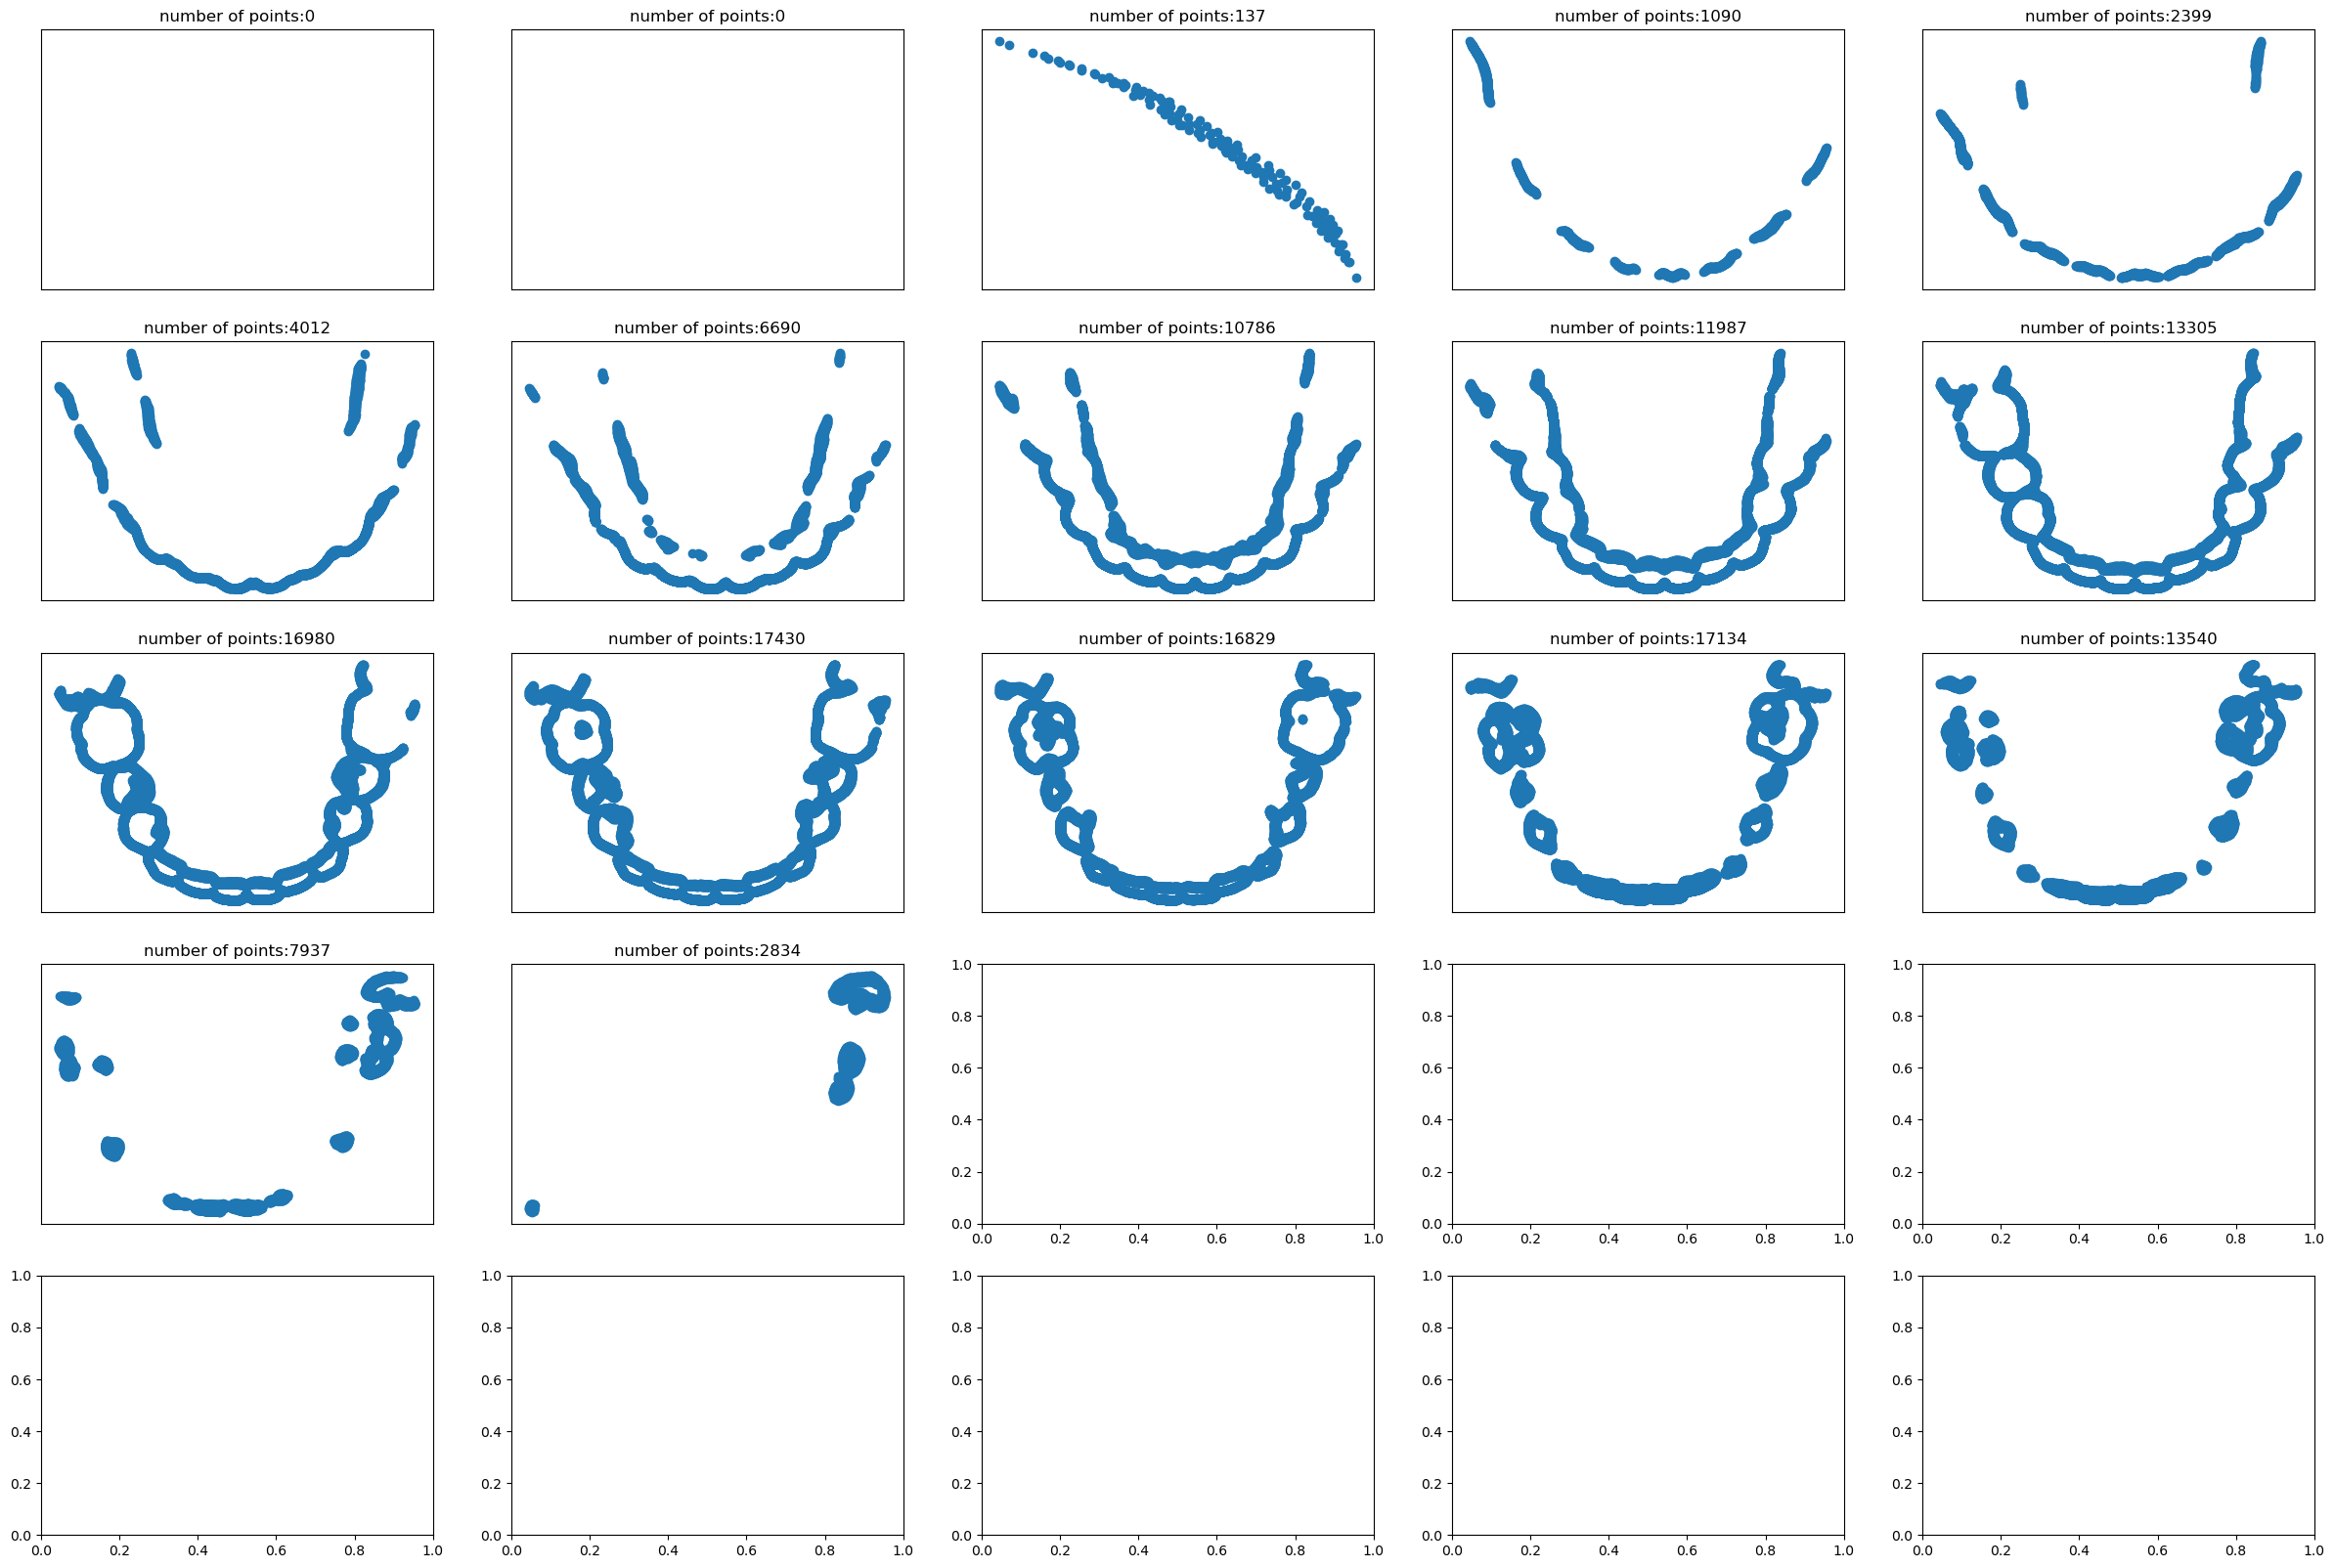

In [22]:
import matplotlib.pyplot as plt
import numpy as np
offset=20
step=0.6

final_stack=[]
for i in range(int(np.ceil(10/step))):
    points=np.array(pcd2.points)
    mask1=points[:,2]<offset+(i+1)*step
    mask2=points[:,2]>offset+i*step
    stack=points[mask1 & mask2]
    final_stack.append(stack)
fig,ax=plt.subplots(int(np.ceil(10/step/5)+1),5,figsize=(30,20))
for j in range(int(np.ceil(10/step/5))):
    for i in range(5):
        try:
            ax[j,i].scatter(final_stack[5*j+i][:,0],final_stack[5*j+i][:,1])
            ax[j,i].set_title(f"number of points:{len(final_stack[5*j+i])}")
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
        except IndexError:
            try:
                ax[i].scatter(final_stack[5*j+i][:,0],final_stack[5*j+i][:,1])
                ax[i].set_title(f"number of points:{len(final_stack[5*j+i])}")
                ax[i].set_xticks([])
                ax[i].set_yticks([])
            except AttributeError:
                break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-31.271564336121422 -19.659648164467725
0.0 1.0
11 teeth detected


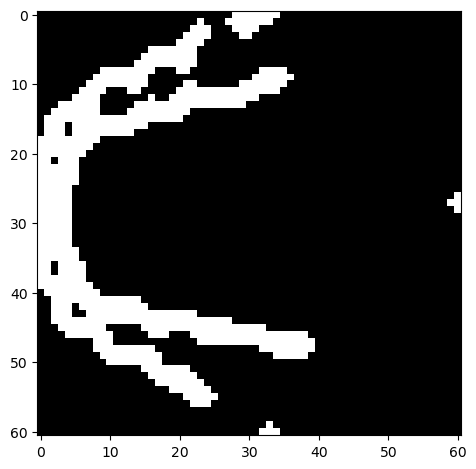

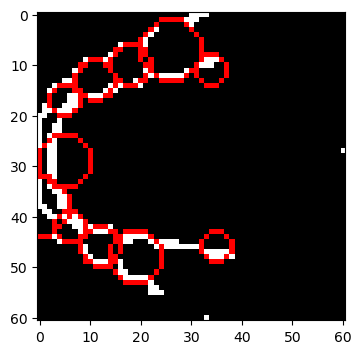

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.0
9 teeth detected


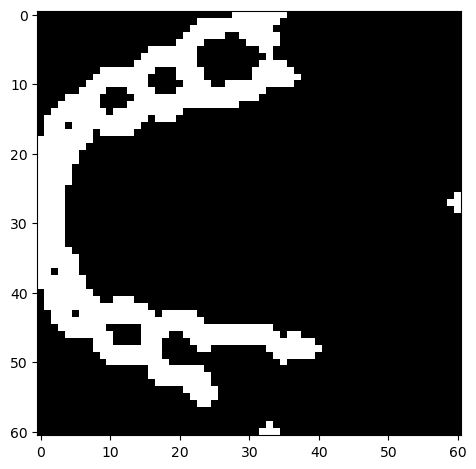

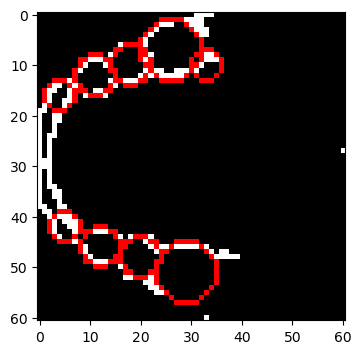

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.0
10 teeth detected


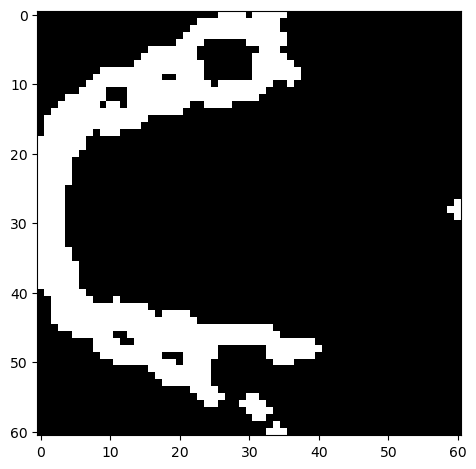

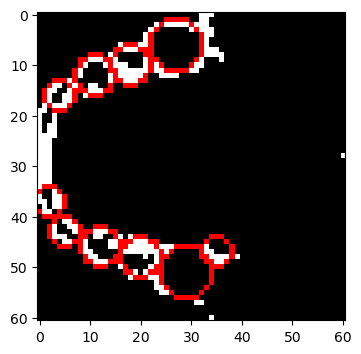

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.0
9 teeth detected


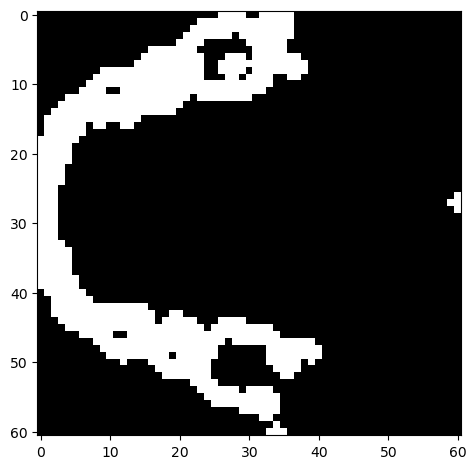

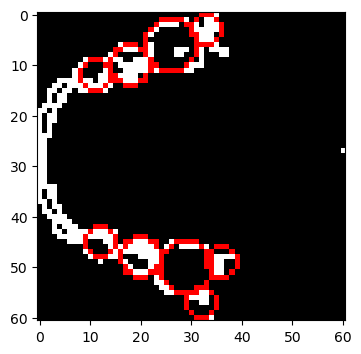

In [134]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.morphology import binary_dilation
from skimage.draw import circle_perimeter
from skimage.io import imshow

def detect_teeth_circle(point_cloud,number_teeth=10,num_points=1e4):
    # Load picture and detect edges
    #create an image from list of points
    if len(point_cloud)<num_points:
        return -1,[]
    a=point_cloud[:,0]-np.min(point_cloud[:,0])
    b=point_cloud[:,1]-np.min(point_cloud[:,1])
    x_shape = 60
    y_shape = 60

    image = np.zeros((x_shape+1, y_shape+1))

    indices = np.stack([a-1,b-1], axis =1).astype(int)
    image[indices[:,0], indices[:,1]] = 1
    #edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)
    print(np.min(image),np.max(image))

    # Detect two radii
    hough_radii = np.arange(3, 7, 1)
    #hough_res = hough_circle(binary_closing(image), hough_radii)
    f=binary_dilation
    imshow(f(image))
    hough_res = hough_circle(f(image), hough_radii)

    # Select the most prominent 3 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,min_xdistance=5,min_ydistance=5,
                                            total_num_peaks=number_teeth)
    print(f"{len(radii)} teeth detected")
    # Draw them
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image_color = color.gray2rgb(image)
    list_center=[]
    for center_y, center_x, radius in zip(cy, cx, radii):
        list_center.append([center_x,center_y])
        circy, circx = circle_perimeter(center_y, center_x, radius,
                                        shape=image.shape)
        image_color[circy, circx] = (255, 0, 0)

    ax.imshow(image_color)
    plt.show()
    return image,list_center
list_centers=[]
print(np.min(final_stack[9][:,0]),np.min(final_stack[9][:,1]))
for stack in final_stack[8:12]:
    edges,center=detect_teeth_circle(stack,number_teeth=11)
    list_centers+=center
list_centers=np.array(sorted(list_centers,key=lambda l:l[0]))

c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


point cloud has 13 clusters


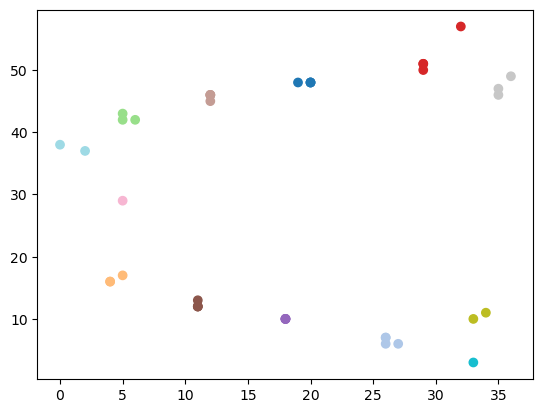

In [24]:

import numpy as np
from sklearn.cluster import KMeans
import open3d as o3d
from copy import deepcopy

import matplotlib.pyplot as plt
# Perform K-means clustering
num_clusters = 13  # Number of desired clusters
kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(list_centers)

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
#pcd2=deepcopy(pcd_truncated)
plt.scatter(list_centers[:,0],list_centers[:,1],c=colors)

In [47]:
z_min=offset+(8+1)*step
z_max=offset+(11+1)*step
z_min,z_max

(25.4, 27.2)

In [51]:
ax = fig.add_subplot(projection='3d')
ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],np.mean([z_min,z_max])*np.ones_like(kmeans.cluster_centers_[:,1]))
plt.show()

array([[19.75      , 48.        , 26.3       ],
       [26.25      ,  6.5       , 26.3       ],
       [ 4.33333333, 16.33333333, 26.3       ],
       [ 5.33333333, 42.33333333, 26.3       ],
       [29.75      , 52.25      , 26.3       ],
       [18.        , 10.        , 26.3       ],
       [11.        , 12.25      , 26.3       ],
       [12.        , 45.75      , 26.3       ],
       [ 5.        , 29.        , 26.3       ],
       [35.33333333, 47.33333333, 26.3       ],
       [33.5       , 10.5       , 26.3       ],
       [33.        ,  3.        , 26.3       ],
       [ 1.        , 37.5       , 26.3       ]])

In [25]:
def dist(elem1,elem2):
    return np.sqrt((elem1[0]-elem2[0])**2+(elem1[1]-elem2[1])**2)

def mean_circle(elem1,elem2):
    return [(elem1[0]+elem2[0])/2,(elem1[1]+elem2[1])/2]

In [26]:
def reduce_circles(list_centers,max_dist=10,repeat=0):
        new_circles=[]
        list_centers2=deepcopy(list_centers)
        i=0
        while len(list_centers2)>1:
                first_circle=list_centers2[0]
                n=len(list_centers2)
                for j in range(1,n):
                        second_circle=list_centers2[j]
                        deleted=False
                        if dist(first_circle,second_circle)<max_dist:
                                deleted=True
                                list_centers2=np.delete(list_centers2,j,axis=0)
                                list_centers2=np.delete(list_centers2,0,axis=0)
                                break
                                
                if deleted:
                        new_circles.append(mean_circle(first_circle,second_circle))
                else:
                        list_centers2=np.delete(list_centers2,0,axis=0)
                        new_circles.append(mean_circle(first_circle,first_circle))
        if len(list_centers2)==1:
                new_circles.append(list_centers[0])
        new_circles=np.array(new_circles)
        for i in range(repeat):
                plt.scatter(new_circles[:,0],new_circles[:,1])
                return reduce_circles(new_circles,max_dist=max_dist,repeat=repeat-1)
        return new_circles

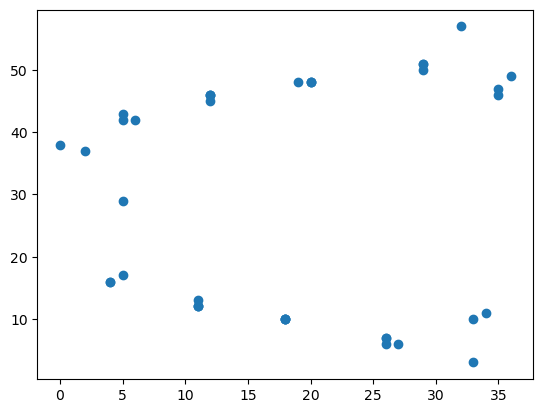

In [27]:
plt.scatter(list_centers[:,0],list_centers[:,1])

5


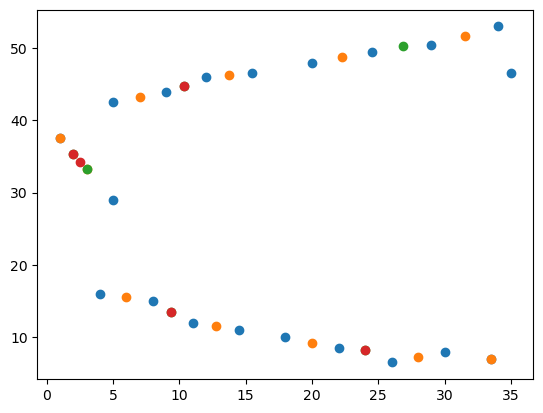

In [28]:
repeat=3
circles=reduce_circles(list_centers,max_dist=10,repeat=repeat)
print(len(circles))
plt.scatter(circles[:,0],circles[:,1])

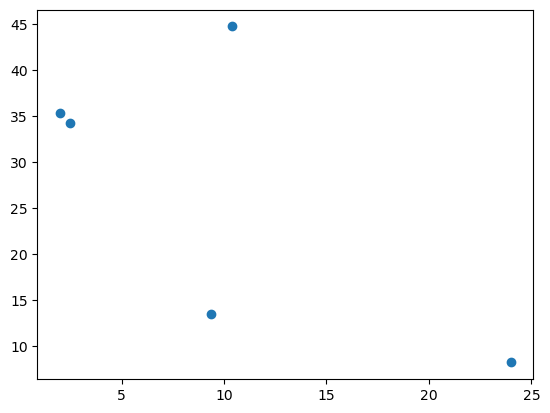

In [29]:
plt.scatter(circles[:,0],circles[:,1])

In [30]:
def remove_outlier(circles,cutoff=0.15):
    new_circles=circles[circles[:,0]<np.mean(circles,axis=0)[0]*(2-cutoff)]
    new_circles=new_circles[new_circles[:,1]<np.mean(circles,axis=0)[1]*(2-cutoff)]
    new_circles=new_circles[new_circles[:,0]>np.mean(circles,axis=0)[0]*cutoff]
    new_circles=new_circles[new_circles[:,1]>np.mean(circles,axis=0)[1]*cutoff]
    return new_circles

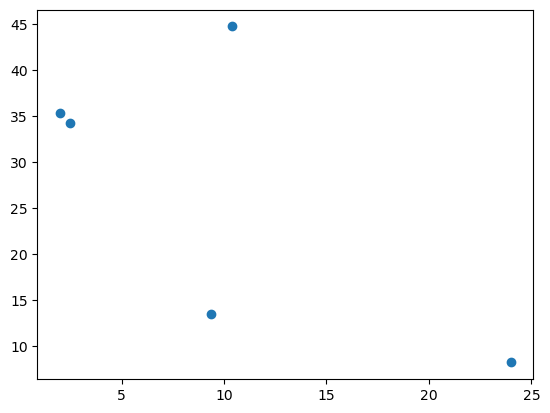

In [31]:
plt.scatter(circles[:,0],circles[:,1])

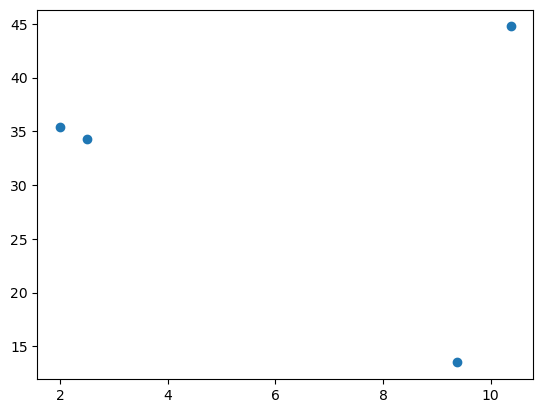

In [17]:
no_circles=remove_outlier(circles,cutoff=0.05)
plt.scatter(no_circles[:,0],no_circles[:,1])

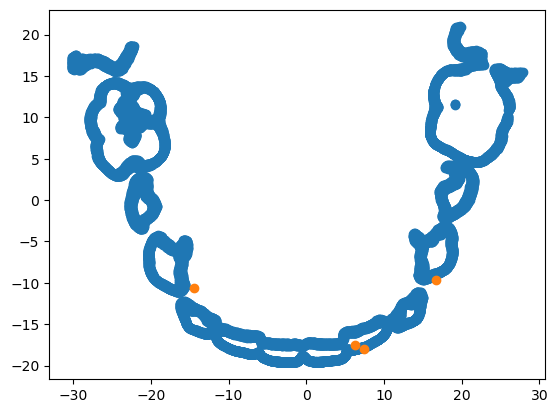

In [32]:
plt.scatter(final_stack[12][:,0],final_stack[12][:,1])
plt.scatter(no_circles[:,1]-28,no_circles[:,0]-20)

In [37]:
import numpy as np
from stl import mesh
# Initialize an empty graph
graph = {}
path=r"C:\Users\Emman\Desktop\JE\Ortho\OrthoCAD_Export_64406802\64406802_shell_occlusion_l.stl"
your_mesh = mesh.Mesh.from_file(path)
# Iterate through each triangle in the mesh
for i, triangle in enumerate(your_mesh.vectors):
    for j in range(3):
        vertex = tuple(triangle[j])
        # Add the vertex and its adjacent triangles to the graph
        if vertex not in graph:
            graph[vertex] = []
        graph[vertex].append(i)

In [156]:
def compare_tuple(tuple1,tuple2):
    return np.sqrt((tuple1[0]-31.351965786817185-tuple2[0])**2+(tuple1[1]-19.668521306410813-tuple2[1])**2+(tuple1[2]-tuple2[2])**2)
#np.min(np.array(pcd2.points)[:,1])

In [161]:
len(graph.keys())*len(markers_init)

1532713

In [167]:
from IPython.display import clear_output
new_markers_init=[]
i=0
for marker in markers_init:

    dist=np.inf
    for key in graph.keys():
            i+=1
        if dist>compare_tuple(marker,key):
            master_key=key
        print(i)
        if i%10==0:
            clear_output(wait=True)
    new_markers_init.append(master_key)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1



1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

KeyboardInterrupt: 

In [166]:
new_markers_init

[(-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401),
 (-6.139314, 25.864977, 16.082401)]

In [165]:
markers_init

[(19.75, 48.0, 26.299999999999997),
 (26.25, 6.5, 26.299999999999997),
 (4.333333333333336, 16.333333333333336, 26.299999999999997),
 (5.333333333333336, 42.33333333333333, 26.299999999999997),
 (29.75, 52.25, 26.299999999999997),
 (18.0, 10.0, 26.299999999999997),
 (11.0, 12.25, 26.299999999999997),
 (12.0, 45.75, 26.299999999999997),
 (5.0, 29.0, 26.299999999999997),
 (35.33333333333333, 47.33333333333333, 26.299999999999997),
 (33.5, 10.5, 26.299999999999997),
 (33.0, 3.0, 26.299999999999997),
 (1.0, 37.5, 26.299999999999997)]

In [93]:
from queue import PriorityQueue

def compute_curvature(point, neighbors, graph):
    # Convert the point to a numpy array
    p = np.array(point)

    # Calculate vectors from the point to its neighbors
    vectors = []
    for neighbor_index in neighbors:
        neighbor_point = graph[list(graph.keys())[neighbor_index]]
        neighbor_point = np.array(neighbor_point)
        vectors.append(neighbor_point - p)

    # Calculate the cross product of the vectors
    cross_product = np.cross(vectors[0], vectors[1])

    # Calculate the magnitude of the cross product
    cross_product_mag = np.linalg.norm(cross_product)

    # Calculate the magnitudes of the vectors
    vectors_mags = [np.linalg.norm(v) for v in vectors]

    # Compute curvature as the reciprocal of the radius of the osculating circle
    if cross_product_mag == 0:
        return float('inf')  # Curvature for a straight line
    else:
        curvature = (2.0 * cross_product_mag) / (vectors_mags[0] * vectors_mags[1] * (vectors_mags[0] + vectors_mags[1]))
        return curvature

# Perform BFS traversal to mark nodes inside tooth radius
def bfs_for_marker(graph, start_node, visited, markers):
    stack = PriorityQueue()
    stack.put((0, start_node))  # Use priority queue for minimum curvature
    
    while not stack.empty():
        curv, node = stack.get()
        visited.add(node)   
        
        # Check if this node should be marked
        if should_mark_node(node, markers):
            markers.add(node)
        
        # Add adjacent nodes to the stack with their curvature
        for neighbor in get_adjacent_nodes(graph, node):  # Implement this function
            if neighbor not in visited:
                neighbor_curv = compute_curvature(neighbor, graph[node], graph)
                stack.put((neighbor_curv, neighbor))


# Check if a node should be marked based on markers
def should_mark_node(node, markers):
    return node not in markers

# Function to get adjacent nodes for a given node index
def get_adjacent_nodes(graph, node):
    neighbors = graph[node]
    return neighbors

# Function to get the front lower node (assuming it's the first node)
def get_front_lower_node(graph):
    return list(graph.keys())[0]

# Function to get the back lower node (assuming it's the second node)
def get_back_lower_node(graph):
    return list(graph.keys())[1]

# Function to get the origin of a specific tooth (replace 'tooth_id' with the desired tooth ID)
def get_tooth_origin(graph, tooth_id):
    for point, neighbors in graph.items():
        if tooth_id in neighbors:
            return point
    return None  # Tooth ID not found in the graph


# Initialize markers for teeth and lower parts using a list of 3D points
def initialize_markers(graph, num_teeth, markers_init):
    # Initialize markers with the provided list of 3D points
    markers = set(markers_init)
    
    # Start BFS traversal from one of the markers
    start_node = markers_init[0]
    bfs_for_marker(graph, start_node, set(), markers)
    return markers

# Example usage
num_teeth = 15  # Replace with the actual number of teeth
graph = graph
markers_init=np.array([kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],np.mean([z_min,z_max])*np.ones_like(kmeans.cluster_centers_[:,1])]).T  # Replace with your 3D graph data structure
markers_init=[tuple(_) for _ in markers_init]
markers = initialize_markers(graph, num_teeth, markers_init)
print("Markers:", markers)






KeyError: (19.75, 48.0, 26.299999999999997)